In [1]:
%matplotlib inline
import parcels
from parcels import FieldSet, Field, AdvectionRK4_3D, AdvectionRK4, TimeConverter
from parcels import ErrorCode, Variable, FieldSamplingError, plotTrajectoriesFile
from parcels import JITParticle, ScipyParticle, ParticleFile, ParticleSet
from parcels import logger, XarrayDecodedFilter, GeographicPolar, Geographic
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
from matplotlib import pyplot as plt, animation
import cartopy
import datetime as dati
import netCDF4 as ntc
from operator import attrgetter
import time as tm
import os
from os import chdir, getcwd
import math
from math import sqrt, pi, cos
import warnings as wr
from glob import glob

In [2]:
# For working on home computer
os.chdir("E:\\OceanParcels for real\\")

scens = np.array(["S0", "S1", "S2", "S3", "S4", "S5", "S6"])
mon_1 = np.array(["05", "06", "07", "08", "09", "10"])
mon_2 = np.array(["may", "jun", "jul", "aug", "sep", "oct"])

Loads up all the data previously generated and saved.

### Attenuate flow field

This is the important bit! I've chosen to attenuate U and V but not W, so that particle ($\kappa$) velocity 
$UVW_{\kappa} = \sqrt{(u_c \cdot U)^2+(u_c \cdot V)^2 + W^2}$ instead of
$UVW_{\kappa} = \sqrt{(u_c \cdot U)^2+(u_c \cdot V)^2 + (u_c \cdot W)^2}$.

I've done this for a few reasons. First, W is a lot smaller than U and V (see above printout) so it probably won't make too much of a difference. But more importantly, Plew's formula calculates depth-averaged attenuation and was derived through a mixture of theory and experimentation, so it seems to me like it's already taken W into account implicitly. Plus, if I attenuate W then the behaviour of particles will be changed such that they will have more difficulty "falling out" of the canopy because I'll at least partially be attenuating gravity, which is the opposite of how it works in real life.

In [3]:
%%script echo Skipped!

# Fix the times_secs coordinates
tt = sum(np.shape(ds3D_all.t.values))
times_secs = np.linspace(start = 0, num = tt, stop = (tt-1)*dati.timedelta(minutes = 10).total_seconds())
print("New end date: ",dati.datetime(2022,4,30,hour=14) + dati.timedelta(seconds=int(times_secs[tt-1])))
ds3D_all.assign_coords(times_secs = ('t', times_secs))

ds3D_all.to_netcdf("../data/processed/Attenuated_"+scens[sc]+"_alltimes.nc")

del ds3D_all

Skipped!


## Construct fieldset

Load into an xarray, it's the easiest way to build the fieldset without screwing up the units (might have been a contributing factor in the tiny velocitiy problem!). Still have to call them U and V though otherwise parcels won't recognise them.

In [4]:
logger.addFilter(XarrayDecodedFilter())  # Add a filter for the xarray decoding warning

final_path = "E:\\OceanParcels for real\\data\\processed\\final grids\\"
coords = "E:\\OceanParcels for real\\data\\processed\\coordinates.nc"
scen = '_S0.nc'

files = [final_path + 'final_may' + scen, final_path + 'final_jun' + scen, 
         final_path + 'final_jul' + scen, final_path + 'final_aug' + scen, 
         final_path + 'final_sep' + scen, final_path + 'final_oct' + scen]

with xr.open_dataset(coords) as cs:
    lon_grid = cs.lon_grid.values
    lat_grid = cs.lat_grid.values
    dep_grid = cs.dep_grid.values
    
with xr.open_dataset(files[0]) as ds:
    times_secs = ds.times_secs.values
    U_atten = ds.U_atten.values
    V_atten = ds.V_atten.values
    W_atten = ds.W_atten.values

vals = {'U': U_atten, 'V': V_atten, 'W': W_atten}

dims = {'U': {'lon': lon_grid, 'lat': lat_grid, 'depth': dep_grid,  'time': times_secs},
        'V': {'lon': lon_grid, 'lat': lat_grid, 'depth': dep_grid,  'time': times_secs},
        'W': {'lon': lon_grid, 'lat': lat_grid, 'depth': dep_grid,  'time': times_secs}}

fset = FieldSet.from_data(data = vals,
                          dimensions = dims,
                          #timestamps = [ds.times.values],
                          #chunksize = 'auto', # might help if using from_netcdf?
                          gridindexingtype = 'nemo')

print("You have created a fieldset with grid type: %s" %fset.W.grid.gtype)

You have created a fieldset with grid type: GridCode.CurvilinearSGrid


## Check it looks ok

You'll notice that at on May 1st you can't see the canopy at all (the macroalgae is very small) but at day 30 you can just barely make out its influence on U (if you're not looking at S0).

In [5]:
#dati.timedelta(seconds=int(fset.U.grid.time_full[-1]))
fset.U.grid.time_full[-1]

2677800.0

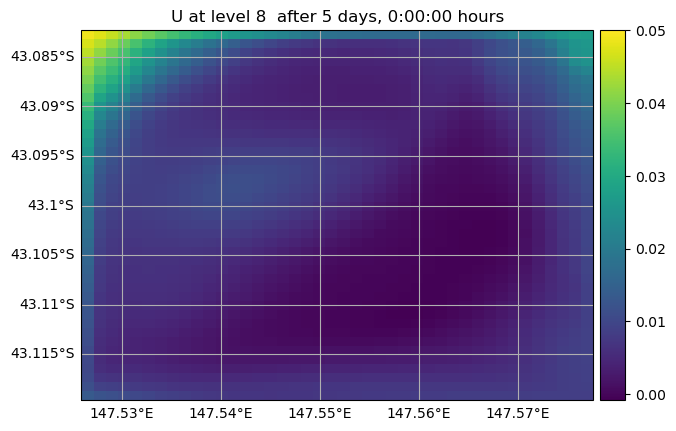

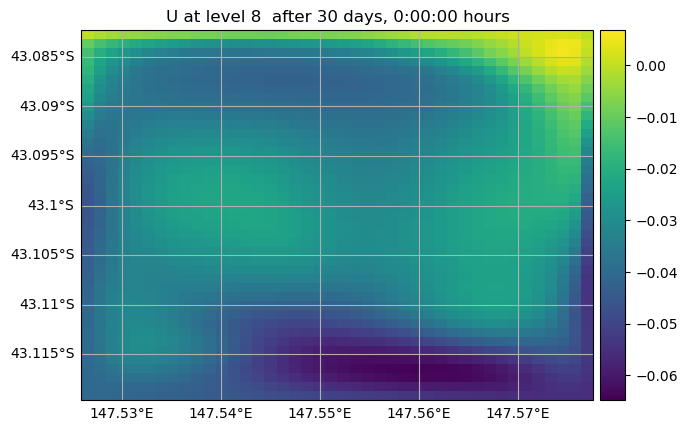

In [7]:
# warnings.simplefilter("ignore", category = UserWarning) # matplotlib doesn't like the edge vs centre axes

fset.U.show(show_time = dati.timedelta(days = 5).total_seconds(),
                depth_level = 8)
fset.U.show(show_time = dati.timedelta(days = 30).total_seconds(), 
                depth_level = 8)

# Run parcels

Set up particles first. The below code generates 240 random 3D coordinates, and then the particles are released at those coordinates one at a time, 2 minutes apart, for the whole runtime.

In [90]:
class SpeedyParticle(ScipyParticle):
    res_time = Variable('res_time', initial = 0., dtype = np.float32, to_write = True) # total time existing
    dist = Variable('dist', initial = 0., dtype = np.float32, to_write = True)
    prev_lon = Variable('prev_lon', dtype = np.float32, to_write = False, initial = attrgetter('lon'))
    prev_lat = Variable('prev_lat', dtype = np.float32, to_write = False, initial = attrgetter('lat'))
    prev_dep = Variable('prev_dep', dtype = np.float32, to_write = False, initial = attrgetter('depth'))
    
def Sample_Stuff(particle, fieldset, time):
    from math import cos, pi, sqrt # don't know why this doesn't carry over
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2 # 1.11e2 km per degree latitude
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * cos(particle.lat * pi/180) # cosine(latitude)-spherical earth
    ver_dist = (particle.depth - particle.prev_dep)/1e3
    
    particle.dist += sqrt(pow(lon_dist, 2) + pow(lat_dist, 2) + pow(ver_dist, 2))
    particle.res_time += particle.dt
    
    # Set the stored values for next iteration
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat
    particle.prev_dep = particle.depth

# Normal 3D advection kernel + custom field sampling
pkern = pset.Kernel(AdvectionRK4_3D) + pset.Kernel(Sample_Stuff)

def DeleteParticle(particle, fieldset, time): 
    particle.delete() # Deletes particle if it's out of bounds

In [130]:
# Releases 30 particles at grid of lats, lons and deps every ten hours
lon_range = np.linspace(fset.U.grid.lon[2,2], fset.U.grid.lon[39,40], num = 10)
lat_range = np.linspace(fset.U.grid.lat[2,2], fset.U.grid.lat[39,40], num = 10)

# Create a grid of particles
plons = np.repeat(lon_range, 10)
plats = np.tile(lat_range, 10)

# Randomise depths from list of possibilities
dep_range = np.linspace(0.5, 40, num = 200) # constrained depth so they don't get stuck on the bottom - does it work?
pdeps = np.random.choice(dep_range, size = 100)

print(np.shape(plons), np.shape(plats), np.shape(pdeps))

(100,) (100,) (100,)


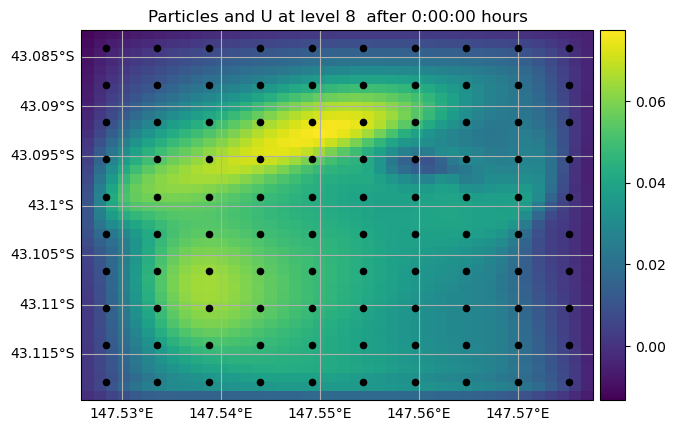

P[14254](lon=147.575150, lat=-43.117802, depth=38.809044, res_time=0.000000, dist=0.000000, time=0.000000)
P[14255](lon=147.575150, lat=-43.114059, depth=31.464825, res_time=0.000000, dist=0.000000, time=0.000000)
P[14256](lon=147.575150, lat=-43.110317, depth=13.798995, res_time=0.000000, dist=0.000000, time=0.000000)
P[14257](lon=147.575150, lat=-43.106575, depth=20.547739, res_time=0.000000, dist=0.000000, time=0.000000)
P[14258](lon=147.575150, lat=-43.102833, depth=21.738693, res_time=0.000000, dist=0.000000, time=0.000000)
P[14259](lon=147.575150, lat=-43.099094, depth=31.464825, res_time=0.000000, dist=0.000000, time=0.000000)
P[14260](lon=147.575150, lat=-43.095352, depth=22.334171, res_time=0.000000, dist=0.000000, time=0.000000)
P[14261](lon=147.575150, lat=-43.091610, depth=8.439698, res_time=0.000000, dist=0.000000, time=0.000000)
P[14262](lon=147.575150, lat=-43.087868, depth=1.889447, res_time=0.000000, dist=0.000000, time=0.000000)
P[14263](lon=147.575150, lat=-43.084126

In [131]:
pset = ParticleSet.from_list(fieldset = fset, pclass = SpeedyParticle, 
                             lon = plons, #np.random.uniform(*lon_range, size = (npart, )), 
                             lat = plats, #np.random.uniform(*lat_range, size = (npart, )), 
                             depth = pdeps, #np.random.uniform(*dep_range, size = (npart, )), 
                             time = np.zeros(100),
                             repeatdt = dati.timedelta(hours = 10).total_seconds())
pset.populate_indices() # more computationally efficient?
pset.show(field = fset.U, depth_level = 8)
pset

# Execute!

Did a bit of testing - generally, it takes less time to run particles with a repeatdt value than it does to run the same number of particles with their own assigned times. Run dt was 30 minutes and output dt was 1 hour for both tests.

New test: pset.time is in format dati.timedelta().total_seconds(), pset.repeatdt is in format dati.timedelta(), but all times in pset.ParticleFile (outputdt) and pset.execute (runtime and dt) are in format dati.timedelta(). Does that come out correctly?

In [ ]:
%%time

outname = "outputs/atten_run_S0_may.zarr"
outfile = pset.ParticleFile(name = outname, outputdt = dati.timedelta(hours = 1))

pset.execute(pkern, output_file = outfile,
             runtime = dati.timedelta(days = 31),
             dt = dati.timedelta(minutes = 10),
             recovery = {ErrorCode.ErrorOutOfBounds: DeleteParticle})

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


INFO: Output files are stored in outputs/atten_run_S0_may.zarr.
  0%|          | 0/2678400.0 [00:00<?, ?it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  1%|          | 18000.0/2678400.0 [00:03<08:47, 5039.36it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  1%|          | 21600.0/2678400.0 [00:07<18:09, 2437.45it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  1%|          | 32400.0/2678400.0 [00:14<22:13, 1984.33it/s]C:\ProgramData\anaconda3\envs\parcels\lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
  1%|▏         | 39600.0/2678400.0 [00:21<31:42, 1386.78it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  2%|▏         | 43200.0/2678400.0 [00:25<37:13, 1179.62it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  2%|▏         | 46800.0/2678400.0 [00:30<45:16, 968.59it/s] 

Correct cell not found after 10000 iterations


  2%|▏         | 50400.0/2678400.0 [00:34<45:46, 956.90it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  2%|▏         | 54000.0/2678400.0 [00:38<47:36, 918.59it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  2%|▏         | 57600.0/2678400.0 [00:43<49:38, 879.80it/s]

Correct cell not found after 10000 iterations


  2%|▏         | 61200.0/2678400.0 [00:47<49:13, 886.17it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  2%|▏         | 64800.0/2678400.0 [00:51<48:41, 894.75it/s]

Correct cell not found after 10000 iterations


  3%|▎         | 68400.0/2678400.0 [00:54<46:35, 933.57it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  3%|▎         | 75600.0/2678400.0 [01:04<52:13, 830.56it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  3%|▎         | 79200.0/2678400.0 [01:09<56:21, 768.65it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  3%|▎         | 82800.0/2678400.0 [01:14<57:13, 755.98it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  3%|▎         | 86400.0/2678400.0 [01:20<59:15, 728.96it/s]

Correct cell not found after 10000 iterations


  4%|▍         | 100800.0/2678400.0 [01:37<55:11, 778.41it/s]

Correct cell not found after 10000 iterations


  4%|▍         | 108000.0/2678400.0 [01:48<59:57, 714.46it/s]

Correct cell not found after 10000 iterations


  4%|▍         | 111600.0/2678400.0 [01:54<1:03:02, 678.53it/s]

Correct cell not found after 10000 iterations


  4%|▍         | 115200.0/2678400.0 [01:59<1:02:47, 680.30it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  4%|▍         | 118800.0/2678400.0 [02:04<1:03:23, 672.91it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  5%|▍         | 122400.0/2678400.0 [02:10<1:04:54, 656.38it/s]

Correct cell not found after 10000 iterations


  5%|▍         | 126000.0/2678400.0 [02:15<1:02:40, 678.68it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  5%|▍         | 129600.0/2678400.0 [02:21<1:03:23, 670.17it/s]

Correct cell not found after 10000 iterations


  5%|▍         | 133200.0/2678400.0 [02:26<1:01:42, 687.51it/s]

Correct cell not found after 10000 iterations


  5%|▌         | 136800.0/2678400.0 [02:30<58:58, 718.31it/s]  

Correct cell not found after 10000 iterations


  6%|▌         | 147600.0/2678400.0 [02:48<1:07:41, 623.11it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  6%|▌         | 151200.0/2678400.0 [02:55<1:09:14, 608.31it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  6%|▌         | 154800.0/2678400.0 [03:01<1:12:51, 577.25it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  6%|▌         | 162000.0/2678400.0 [03:12<1:07:09, 624.55it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  6%|▌         | 165600.0/2678400.0 [03:18<1:08:49, 608.55it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  7%|▋         | 183600.0/2678400.0 [03:51<1:16:33, 543.16it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  7%|▋         | 187200.0/2678400.0 [03:58<1:18:19, 530.11it/s]

Correct cell not found after 10000 iterations


  7%|▋         | 190800.0/2678400.0 [04:04<1:16:22, 542.80it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  7%|▋         | 194400.0/2678400.0 [04:11<1:16:11, 543.34it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  7%|▋         | 198000.0/2678400.0 [04:19<1:22:14, 502.66it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  8%|▊         | 201600.0/2678400.0 [04:27<1:25:26, 483.12it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  8%|▊         | 205200.0/2678400.0 [04:34<1:24:06, 490.12it/s]

Correct cell not found after 10000 iterations


  8%|▊         | 208800.0/2678400.0 [04:41<1:20:35, 510.72it/s]

Correct cell not found after 10000 iterations


  8%|▊         | 212400.0/2678400.0 [04:46<1:15:46, 542.34it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  8%|▊         | 216000.0/2678400.0 [05:00<1:38:08, 418.14it/s]

Correct cell not found after 10000 iterations


  8%|▊         | 219600.0/2678400.0 [05:07<1:32:55, 440.98it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  8%|▊         | 223200.0/2678400.0 [05:14<1:30:08, 453.99it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  8%|▊         | 226800.0/2678400.0 [05:22<1:29:04, 458.72it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  9%|▊         | 230400.0/2678400.0 [05:28<1:24:41, 481.79it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


  9%|▉         | 237600.0/2678400.0 [05:42<1:20:16, 506.75it/s]

Correct cell not found after 10000 iterations


  9%|▉         | 241200.0/2678400.0 [05:48<1:17:59, 520.86it/s]

Correct cell not found after 10000 iterations


  9%|▉         | 244800.0/2678400.0 [05:55<1:16:58, 526.90it/s]

Correct cell not found after 10000 iterations


  9%|▉         | 252000.0/2678400.0 [06:15<1:36:31, 418.99it/s]

Correct cell not found after 10000 iterations


 10%|▉         | 255600.0/2678400.0 [06:22<1:34:08, 428.95it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 10%|▉         | 259200.0/2678400.0 [06:30<1:32:00, 438.20it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 10%|▉         | 262800.0/2678400.0 [06:39<1:34:29, 426.04it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 10%|▉         | 266400.0/2678400.0 [06:48<1:33:56, 427.94it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 10%|█         | 270000.0/2678400.0 [06:56<1:32:38, 433.26it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 10%|█         | 273600.0/2678400.0 [07:03<1:30:28, 442.98it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 10%|█         | 277200.0/2678400.0 [07:11<1:27:53, 455.37it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 10%|█         | 280800.0/2678400.0 [07:18<1:24:47, 471.29it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 11%|█         | 284400.0/2678400.0 [07:25<1:21:59, 486.62it/s]

Correct cell not found after 10000 iterations


 11%|█         | 288000.0/2678400.0 [07:38<1:40:48, 395.17it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 11%|█         | 291600.0/2678400.0 [07:47<1:41:04, 393.56it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 11%|█         | 295200.0/2678400.0 [07:56<1:39:41, 398.43it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 11%|█         | 298800.0/2678400.0 [08:04<1:35:33, 415.03it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 11%|█▏        | 302400.0/2678400.0 [08:11<1:32:35, 427.70it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 12%|█▏        | 309600.0/2678400.0 [08:22<1:15:02, 526.14it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 12%|█▏        | 313200.0/2678400.0 [08:28<1:09:46, 564.89it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 12%|█▏        | 316800.0/2678400.0 [08:33<1:05:59, 596.43it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 12%|█▏        | 320400.0/2678400.0 [08:38<1:02:01, 633.58it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 12%|█▏        | 324000.0/2678400.0 [08:51<1:25:33, 458.62it/s]

Correct cell not found after 10000 iterations


 12%|█▏        | 327600.0/2678400.0 [08:57<1:19:44, 491.36it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 13%|█▎        | 338400.0/2678400.0 [09:14<1:06:24, 587.23it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 13%|█▎        | 342000.0/2678400.0 [09:20<1:06:32, 585.15it/s]

Correct cell not found after 10000 iterations


 13%|█▎        | 345600.0/2678400.0 [09:26<1:05:32, 593.20it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 13%|█▎        | 349200.0/2678400.0 [09:34<1:10:02, 554.21it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 13%|█▎        | 352800.0/2678400.0 [09:43<1:19:30, 487.52it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 13%|█▎        | 356400.0/2678400.0 [09:51<1:20:15, 482.24it/s]

Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations
Correct cell not found after 10000 iterations


 13%|█▎        | 360000.0/2678400.0 [10:06<1:44:20, 370.30it/s]

Correct cell not found after 10000 iterations


 14%|█▎        | 363600.0/2678400.0 [10:13<1:35:01, 405.96it/s]

Correct cell not found after 10000 iterations


# Initial plots

These first ones are just to make sure it looks OK. There's a seperate notebook for the proper plotting.

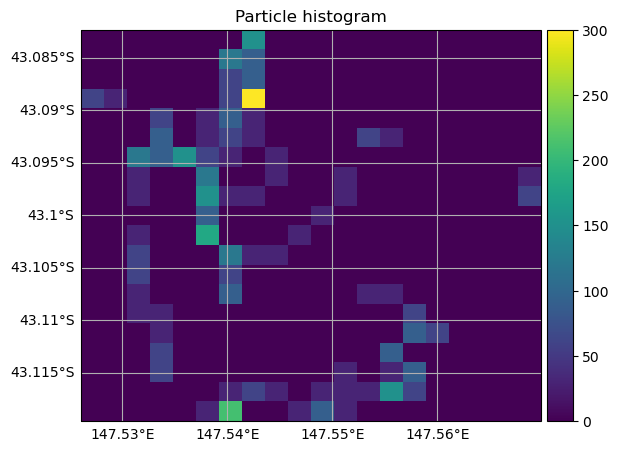

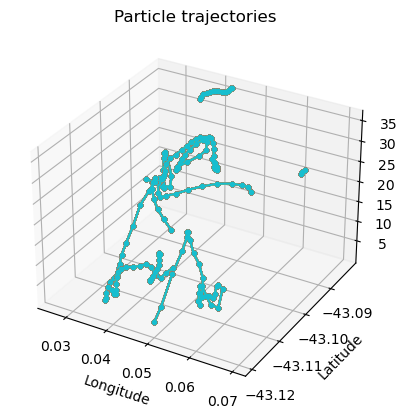

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\anaconda3\\envs\\parcels\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [88]:
#warnings.simplefilter("ignore", category = RuntimeWarning) # This is because xarray is just incessant
#plotTrajectoriesFile(outname, mode = "2d")
plotTrajectoriesFile(outname, mode = "hist2d")
plotTrajectoriesFile(outname, mode = "3d")
#plotTrajectoriesFile(outname, mode = "movie2d_notebook")#, recordedvar = "res_time")
#anim.save("../outputs/particles_"+mo+"_"+sc+".gif")